<h1>Qiskit Hello World!</h1>

In [7]:
%load_ext skip_kernel_extension

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


<h2>Step 0. Obtain the API_KEY from the .env file</h2>

In [8]:
from environs import Env

env = Env()

#env.read_env()                         # this does not work (?)
env.read_env('.env', recurse=False)     # read .env file, if it exists

token = env('IBM_QUANTUM_TOKEN')  

print(f">>> Token: {token[:5]}...")      # Check that the starting characters of the token are printed

>>> Token: 4a7ea...


<h2>Step 1. Create a simple circuit with two entangled qubits (Bell state)</h2>

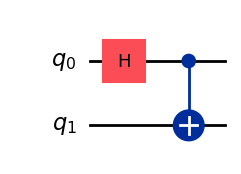

In [9]:
from qiskit import QuantumCircuit

# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

<h2>Step 2. Set up a set of observables</h2>

In [10]:
from qiskit.quantum_info import SparsePauliOp

# Set up six different observables.
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]


<h2>Step 3a. Prepare for execution on simulator</h2>

In [14]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

backend = FakeAlmadenV2()

<h2>Step 3b. Alternatively, prepare for execution on a hardware QPU</h2>

In [13]:
%%skip True
# Set skip magic to True for executing on hardware QPU

from IPython.display import display, Markdown
from qiskit_ibm_runtime import QiskitRuntimeService

display(Markdown('## <span style="color:red">WARNING: *** No simulation. Next steps will run the circuit on hardware QPU ***</span>'))

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
 
backend = service.least_busy(simulator=False, operational=True)

<h2>Step 4. Convert to an ISA circuit layout</h2>

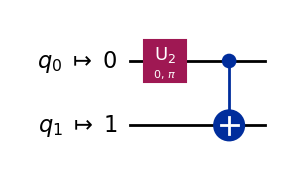

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

<h2>Step 5. Map the observables to the circuit layout, and construct the Estimator instance</h2>

In [16]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Map the observables to the ISA circuit

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# Construct the Estimator instance

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

<h2>Step 6. Run the circuit</h2>

In [17]:

job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]

C:\Carlos\current\Docencia\QSE\IBM Quantum\Hello World\qiskitenv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


>>> Job ID: af8d4130-2e63-472f-9220-729e04785600


<h2>Step 7. Show the results</h2>

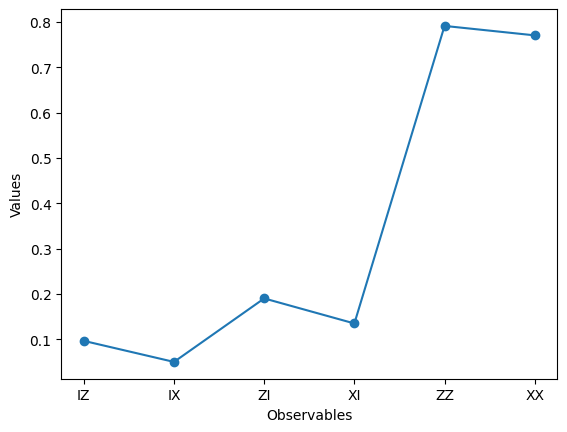

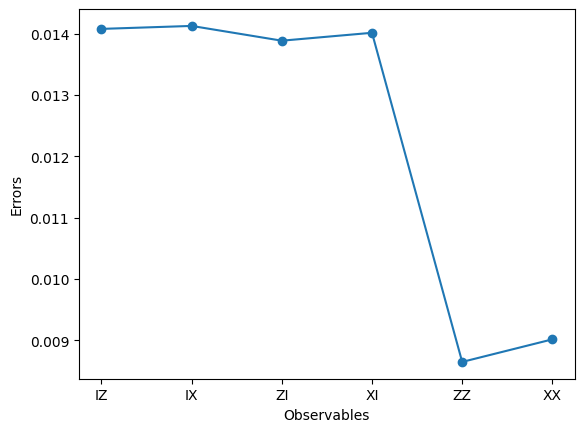

In [18]:
# Plot the results
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

plt.plot(observables_labels, errors, '-o')
plt.xlabel('Observables')
plt.ylabel('Errors')
plt.show()